In [1]:
# Making necessary imports

import pickle
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

For this project, we will be using the text corpus of an ebook ["A Christmas Carol in Prose; Being a Ghost Story of Christmas"](https://www.gutenberg.org/ebooks/46) which is downloaded from Project Gutenberg.

## Data Preparation

In [2]:
with open("data/data.txt", "r", encoding='utf-8-sig') as f:
    text = f.read()
    
# Viewing a portion of the original text
text[:500]

'The Project Gutenberg eBook of A Christmas Carol, by Charles Dickens\n\nThis eBook is for the use of anyone anywhere in the United States and\nmost other parts of the world at no cost and with almost no restrictions\nwhatsoever. You may copy it, give it away or re-use it under the terms\nof the Project Gutenberg License included with this eBook or online at\nwww.gutenberg.org. If you are not located in the United States, you\nwill have to check the laws of the country where you are located before\nusing'

In [3]:
# Some basic preprocessing

text = " ".join(text.split()) # Remove any remaining white spaces
text = text.replace('"', '').replace("'", '') # Remove single and double quotation marks

# Viewing a portion of the preprocessed text
text[:500]

'The Project Gutenberg eBook of A Christmas Carol, by Charles Dickens This eBook is for the use of anyone anywhere in the United States and most other parts of the world at no cost and with almost no restrictions whatsoever. You may copy it, give it away or re-use it under the terms of the Project Gutenberg License included with this eBook or online at www.gutenberg.org. If you are not located in the United States, you will have to check the laws of the country where you are located before using '

In [4]:
# Apply Tokenization

# Fitting tokenizer on text
tokenizer = Tokenizer()
tokenizer.fit_on_texts([text])

# View what the tokenizer has learned
vocab_size = len(tokenizer.word_index)+1
print(f'Total number of unique words: {vocab_size}\n')
print(f"Word Count: {list(tokenizer.word_counts.items())[:5]}\n")
print(f"Document Count: {tokenizer.document_count}\n")
print(f"Word Index: {dict(list(tokenizer.word_index.items())[:5])}")

# Saving the tokenizer
pickle.dump(tokenizer, open("saved_models/tokenizer.pkl", 'wb'))

Total number of unique words: 4701

Word Count: [('the', 1761), ('project', 88), ('gutenberg', 97), ('ebook', 13), ('of', 783)]

Document Count: 1

Word Index: {'the': 1, 'and': 2, 'of': 3, 'a': 4, 'to': 5}


In [5]:
# Transforming text to sequences
sequence_data = tokenizer.texts_to_sequences([text])[0]
print(f'Length of sequence data: {len(sequence_data)}')
print(sequence_data[:5])

Length of sequence data: 32050
[1, 51, 46, 304, 3]


In [6]:
# Creating sequences each having 4 words (first three words are used to predict the fourth word)
sequences = []

for i in range(3, len(sequence_data)):
    words = sequence_data[i-3:i+1]
    sequences.append(words)

sequences = np.array(sequences)
print(f'Total number of sequences: {sequences.shape[0]}')
sequences[:5]

Total number of sequences: 32047


array([[  1,  51,  46, 304],
       [ 51,  46, 304,   3],
       [ 46, 304,   3,   4],
       [304,   3,   4,  50],
       [  3,   4,  50, 505]])

In [7]:
# Taking first 3 words as input and last word as output

X = sequences[:,0:3]
y = sequences[:,3]

# Converting output into binary class matrix
y = to_categorical(y, num_classes=vocab_size)
y[:5]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

## Model Building & Training

In [8]:
# Creating a LSTM model

model = Sequential()
model.add(Embedding(vocab_size, 10, input_length=3))
model.add(LSTM(500, return_sequences=True))
model.add(LSTM(500))
model.add(Dense(500, activation='relu'))
model.add(Dense(vocab_size, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 3, 10)             47010     
                                                                 
 lstm (LSTM)                 (None, 3, 500)            1022000   
                                                                 
 lstm_1 (LSTM)               (None, 500)               2002000   
                                                                 
 dense (Dense)               (None, 500)               250500    
                                                                 
 dense_1 (Dense)             (None, 4701)              2355201   
                                                                 
Total params: 5,676,711
Trainable params: 5,676,711
Non-trainable params: 0
_________________________________________________________________


In [9]:
# Training the model

checkpoint = ModelCheckpoint("saved_models/model.h5", monitor="loss", save_best_only=True)
model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.001))
model.fit(X,y, epochs=50, batch_size=64, callbacks=[checkpoint])

Epoch 1/50
501/501 [==============================] - 43s 80ms/step - loss: 6.7511
Epoch 2/50
501/501 [==============================] - 40s 81ms/step - loss: 6.3257
Epoch 3/50
501/501 [==============================] - 44s 87ms/step - loss: 6.0608
Epoch 4/50
501/501 [==============================] - 46s 92ms/step - loss: 5.7742
Epoch 5/50
501/501 [==============================] - 41s 82ms/step - loss: 5.4874
Epoch 6/50
501/501 [==============================] - 41s 82ms/step - loss: 5.2277
Epoch 7/50
501/501 [==============================] - 44s 88ms/step - loss: 4.9899
Epoch 8/50
501/501 [==============================] - 41s 82ms/step - loss: 4.7622
Epoch 9/50
501/501 [==============================] - 41s 83ms/step - loss: 4.5312
Epoch 10/50
501/501 [==============================] - 44s 87ms/step - loss: 4.2901
Epoch 11/50
501/501 [==============================] - 42s 83ms/step - loss: 4.0290
Epoch 12/50
501/501 [==============================] - 43s 85ms/step - loss: 3.7483
E

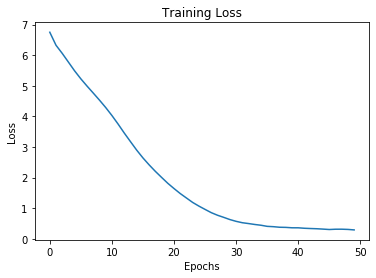

In [10]:
# Plotting loss on each epochs
loss = model.history.history['loss']
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(loss)

## Predicting

In [11]:
# Loading the saved tokenizer and model
tokenizer = pickle.load(open('saved_models/tokenizer.pkl', 'rb'))
model = load_model('saved_models/model.h5')

In [12]:
def predict_next_word(text, tokenizer=tokenizer, model=model):
    sequence = tokenizer.texts_to_sequences([text])
    sequence = np.array(sequence)
    preds = np.argmax(model.predict(sequence))
    word = list(tokenizer.word_index.keys())[list(tokenizer.word_index.values()).index(preds)]
    return word

In [14]:
while True:
    text = input("Enter your sentence here: ")
    if text == "break":
        break
    
    words = text.split()
    if len(words)<3:
        print("Input sentence should have minimum 3 words")
        continue
    word = predict_next_word(words[-3:])
    print(f"Prediction: {word}")

Enter your sentence here:  we were not


Prediction: perfectly


Enter your sentence here:  painted out Old


Prediction: marleys


Enter your sentence here:  External heat and


Prediction: cold


Enter your sentence here:  break
